## Read Narcan calls data from database and build a line chart to view the trend

Properties of the data are :         Narc_Calls
count    43.000000
mean   1020.511628
std     346.166721
min     314.000000
25%     745.500000
50%     978.000000
75%    1318.000000
max    1627.000000


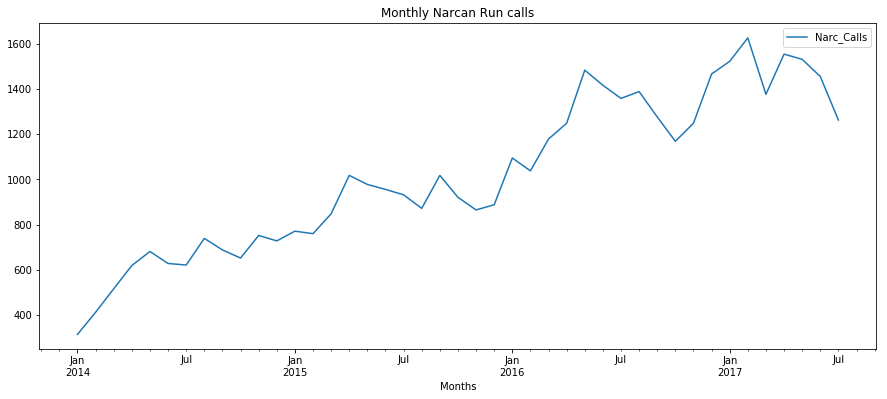

In [38]:
## Narcan Usage analysis from 2014 - 2017

import numpy as np
import matplotlib.pyplot as plt
import MySQLdb
import pandas as pd
import itertools
import statsmodels.api as sm
from datetime import datetime
from calendar import monthrange
import math
import warnings
warnings.filterwarnings("ignore")
def getData(county ):
    county = county
    conn = MySQLdb.connect(host="localhost", user="i501fa18_group7", passwd="rEm9z3dRGW11", db="i501fa18_group7")
    cursor = conn.cursor()
    if(county == 'all'):
        condition = 'NARCANRUN = \'Y\' '
    else :
        condition = ' inc_county = \'%s\' and NARCANRUN = \'Y\' '% (county)
    str1="select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH , count(INC_INCIDENTID) as Numn_of_Narcanrun from i501fa18_group7.emergency_medical_service_runs_2014 Where  %s group by LAST_DAY(INC_INCIDENTDATE)"
    str2=" union select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH , count(INC_INCIDENTID) as Numn_of_Narcanrun  from i501fa18_group7.emergency_medical_service_runs_2015 Where %s group by LAST_DAY(INC_INCIDENTDATE)"
    str3=" union select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH , count(INC_INCIDENTID) as Numn_of_Narcanrun  from i501fa18_group7.emergency_medical_service_runs_2016 Where %s group by LAST_DAY(INC_INCIDENTDATE)"
    str4=" union select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH, count(INC_INCIDENTID) as Numn_of_Narcanrun   from i501fa18_group7.emergency_medical_service_runs_2017 Where  %s  and LAST_DAY(INC_INCIDENTDATE) < \'2017-08-31\' group by LAST_DAY(INC_INCIDENTDATE)"
    query = str1% (condition)+str2% (condition)+str3% (condition)+str4% (condition)
    cursor.execute(query);
    rows = cursor.fetchall() 
    months = []
    narc_calls = []
    for i in rows:
        months.append(datetime.combine(i[0],datetime.min.time()))
        narc_calls.append(i[1])
    my_data = pd.DataFrame(
        {'Months': months,
         'Narc_Calls': narc_calls
        })
    my_data = my_data.set_index('Months')
    return my_data;
def decomposeData(my_data):
    check_seasonal = sm.tsa.seasonal_decompose(my_data, model='multiplicative')
    fig = check_seasonal.plot()
    plt.title('Seasonal trending of the calls data')
    plt.show()
state_wide_NarcCalls = getData('all');
print("Properties of the data are :" , state_wide_NarcCalls.describe())
state_wide_NarcCalls.plot(figsize=(15,6))
plt.title('Monthly Narcan Run calls')
plt.show()




## Seasonal decompose to check if given data is seasonal

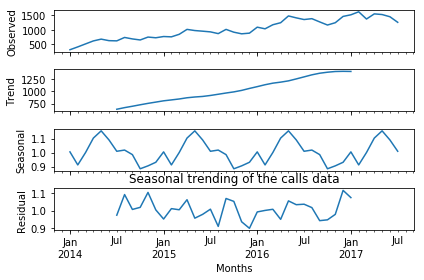

In [39]:
decomposeData(state_wide_NarcCalls)

The seasonal and trend graphs show a seasonal behavior, so we can use the Seasonal ARIMAX model

## Train the SARIMAX model for data from 2014 to 2016

In [58]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

min_aic = 1000
min_param = ()
min_param_seasonal = ()

train_data = state_wide_NarcCalls[:2016]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            train_model = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = train_model.fit()
            if (results.aic <= min_aic):
                min_aic = results.aic
                min_param = param
                min_param_seasonal = param_seasonal
            
        except:
            continue

print('Minimum AIC in observed at ', min_param, min_param_seasonal, min_aic)   
    


Minimum AIC in observed at  (1, 1, 0) (1, 1, 0, 12) 218.44466637575232


## Build SARIMAX model using the parameters for minimum AIC 

In [59]:
    model = sm.tsa.statespace.SARIMAX(state_wide_NarcCalls, 
                                order= min_param,
                                seasonal_order= min_param_seasonal,
                                enforce_stattionary=False,
                                enforce_invertibility=False)

    results = model.fit()

    for i in range(3):
        print(results.summary().tables[i])



                                 Statespace Model Results                                 
Dep. Variable:                         Narc_Calls   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -187.226
Date:                            Sat, 15 Dec 2018   AIC                            380.451
Time:                                    09:03:46   BIC                            384.655
Sample:                                01-31-2014   HQIC                           381.796
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3115      0.259     -1.202      0.229      -0.820       0.197
ar.S.L12      -0.5676      0.302   

## Check diagnostics to make sure the model doesn't produce incorrect results

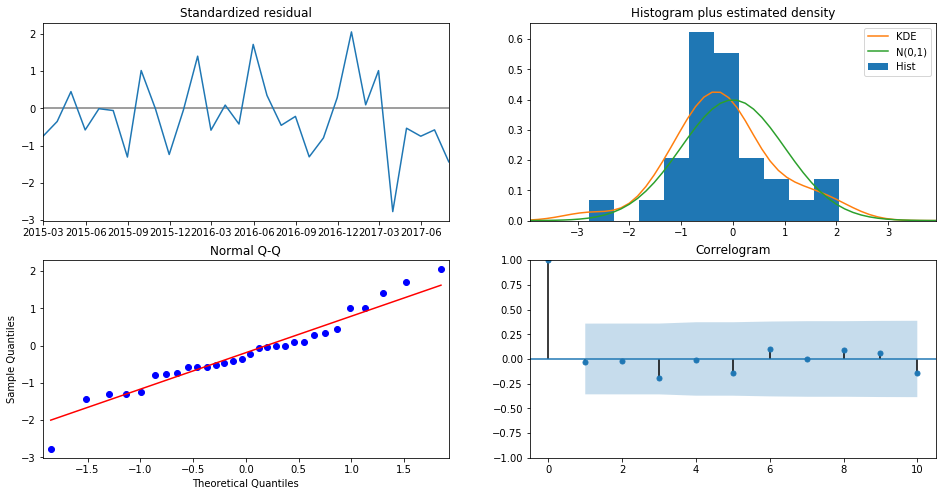

In [8]:
results.plot_diagnostics(figsize=(16,8))
plt.show()


Sample quantities and theoretical quantities showing similar trend 

## Predicting the values for 2017 based on training data...

                                 Statespace Model Results                                 
Dep. Variable:                         Narc_Calls   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -187.226
Date:                            Sat, 15 Dec 2018   AIC                            380.451
Time:                                    09:08:41   BIC                            384.655
Sample:                                01-31-2014   HQIC                           381.796
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3115      0.259     -1.202      0.229      -0.820       0.197
ar.S.L12      -0.5676      0.302   

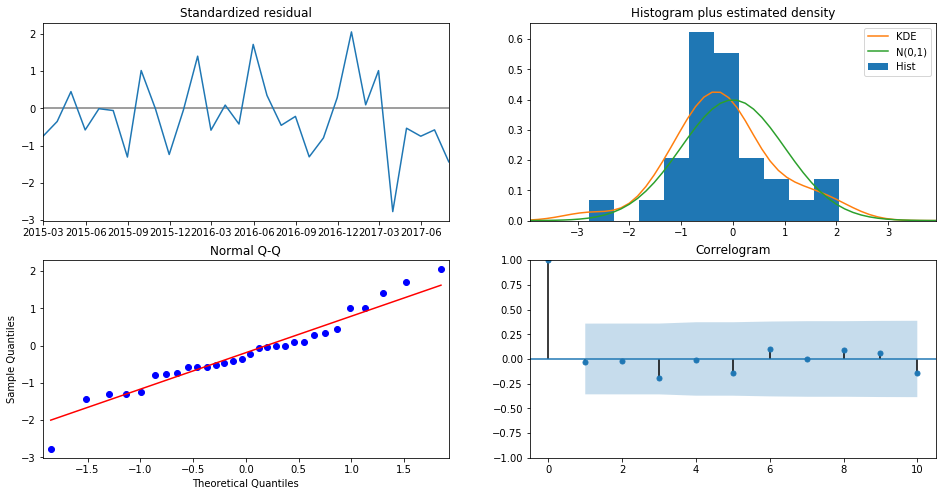

            lower Narc_Calls  upper Narc_Calls
2017-01-31       1286.218601       1737.492508
2017-02-28       1284.514696       1735.788603
2017-03-31       1470.257804       1921.531710
2017-04-30       1390.559873       1841.833780
2017-05-31       1392.312451       1843.586357
2017-06-30       1296.653772       1747.927679
2017-07-31       1202.421957       1653.695864


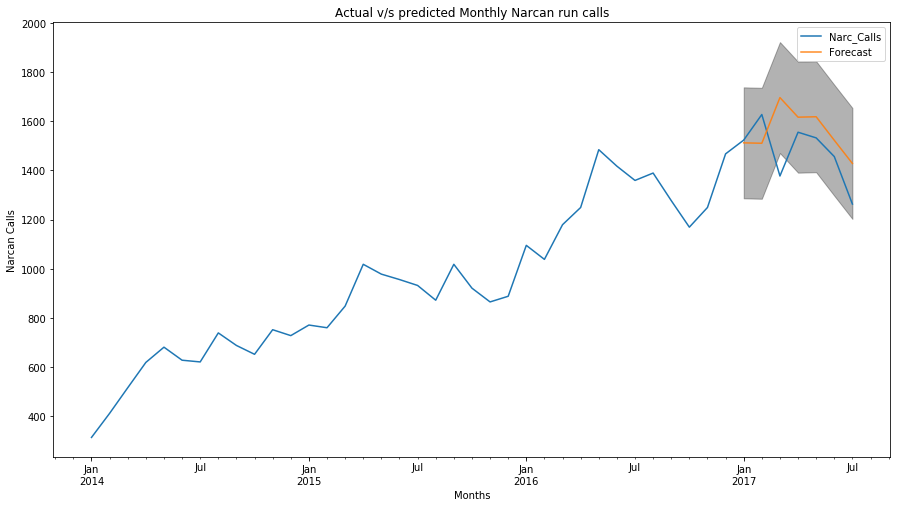

In [62]:
def forecastNarcan(in_data):
    model = sm.tsa.statespace.SARIMAX(in_data, 
                                order= min_param,
                                seasonal_order= min_param_seasonal,
                                enforce_stattionary=False,
                                enforce_invertibility=False)

    results = model.fit()

    for i in range(3):
        print(results.summary().tables[i])
        
    results.plot_diagnostics(figsize=(16,8))
    plt.show()
    
    pred = results.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
    pred_ci = pred.conf_int() 
    ax = in_data['2014':].plot(label='Observed')
    pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9, figsize=(15, 8))
    print(pred_ci)
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.3)
    ax.set_xlabel('Months')
    ax.set_ylabel('Narcan Calls')
    plt.legend()
    plt.title('Actual v/s predicted Monthly Narcan run calls')
    plt.show()

forecastNarcan(state_wide_NarcCalls)

# Model Predict for Marion County

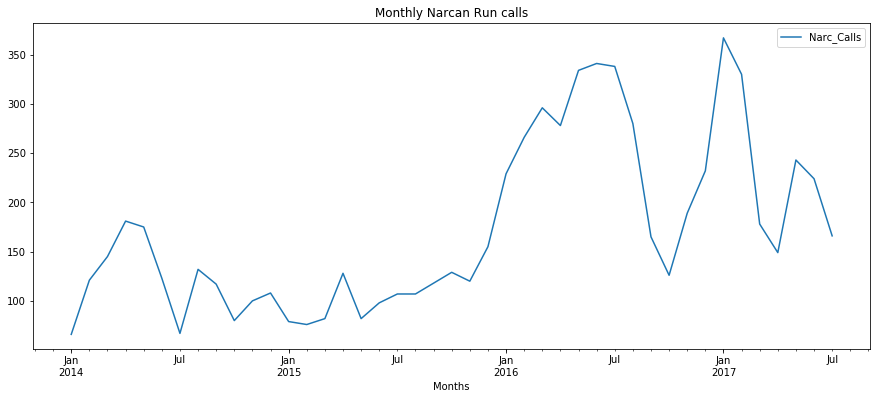

                                 Statespace Model Results                                 
Dep. Variable:                         Narc_Calls   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -167.161
Date:                            Sat, 15 Dec 2018   AIC                            340.322
Time:                                    09:09:08   BIC                            344.526
Sample:                                01-31-2014   HQIC                           341.667
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1458      0.241      0.605      0.545      -0.327       0.618
ar.S.L12      -0.1352      0.326   

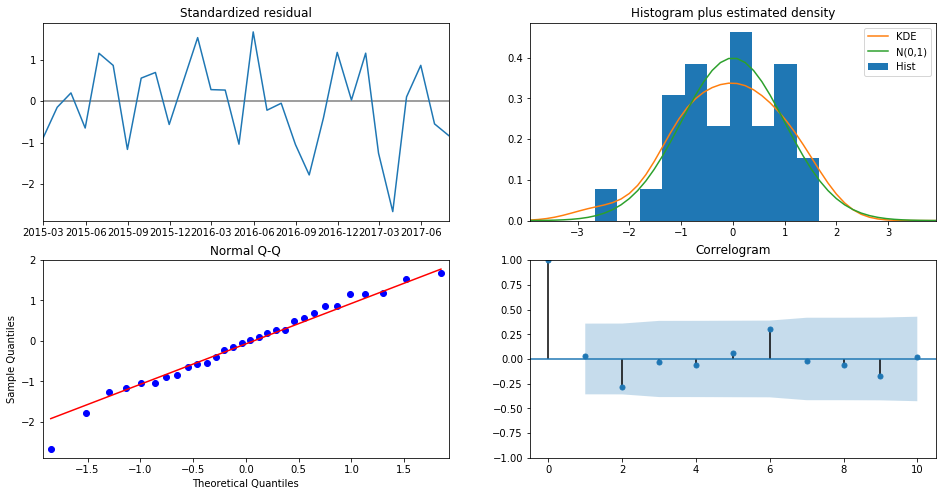

            lower Narc_Calls  upper Narc_Calls
2017-01-31        169.539231        418.001258
2017-02-28        285.285263        533.747290
2017-03-31        222.522151        470.984178
2017-04-30         18.359215        266.821243
2017-05-31         64.109704        312.571732
2017-06-30        134.538124        383.000151
2017-07-31         94.423180        342.885207


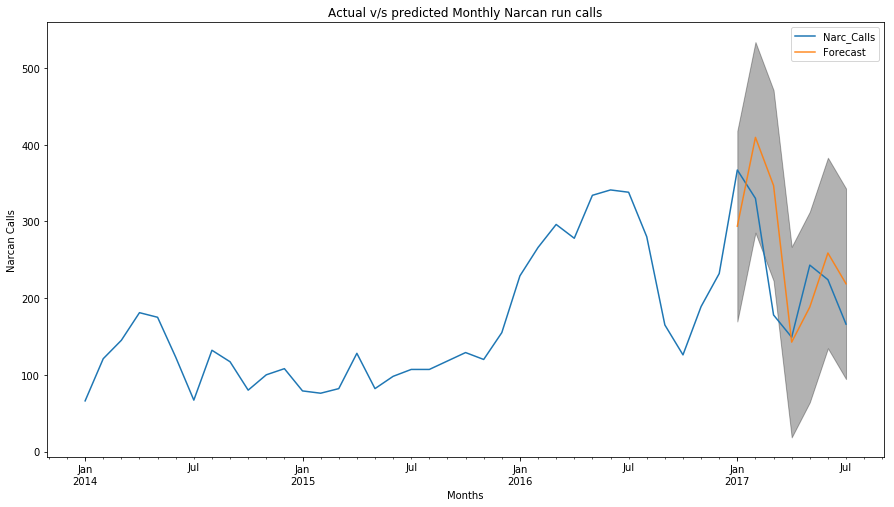

In [63]:
Marion_NarcCalls = getData('Marion')

Marion_NarcCalls.plot(figsize=(15,6))
plt.title('Monthly Narcan Run calls')
plt.show()

forecastNarcan(Marion_NarcCalls)

## Predict for St Joseph County

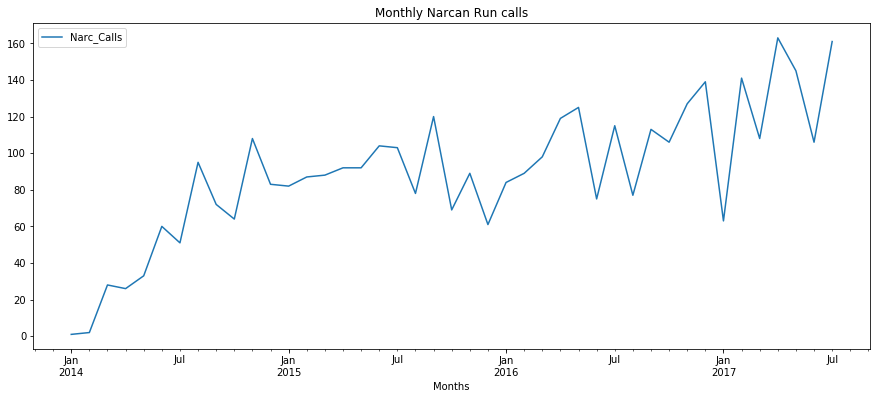

                                 Statespace Model Results                                 
Dep. Variable:                         Narc_Calls   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -142.420
Date:                            Sat, 15 Dec 2018   AIC                            290.839
Time:                                    09:13:21   BIC                            295.043
Sample:                                01-31-2014   HQIC                           292.184
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6588      0.191     -3.442      0.001      -1.034      -0.284
ar.S.L12      -0.2807      0.283   

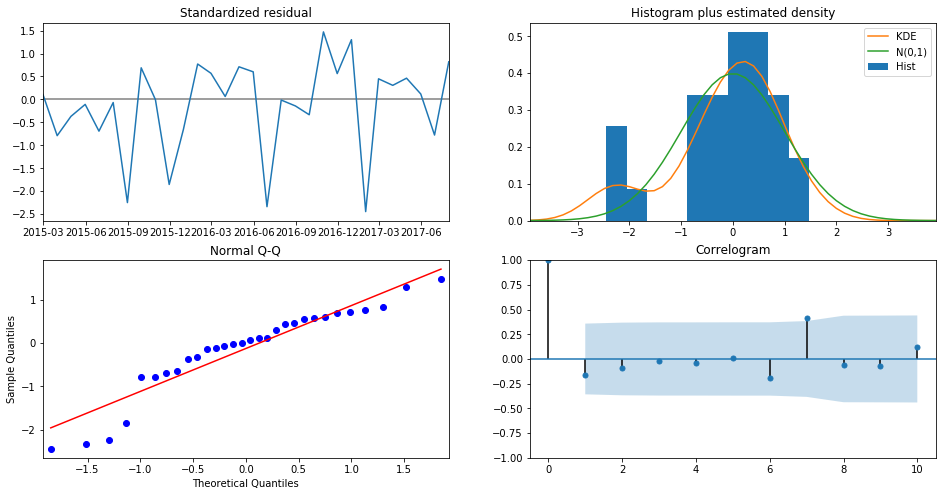

            lower Narc_Calls  upper Narc_Calls
2017-01-31         76.182962        182.747819
2017-02-28         75.505321        182.070177
2017-03-31         46.376833        152.941690
2017-04-30         97.138689        203.703545
2017-05-31         88.489635        195.054492
2017-06-30         73.820687        180.385544
2017-07-31         85.427714        191.992571


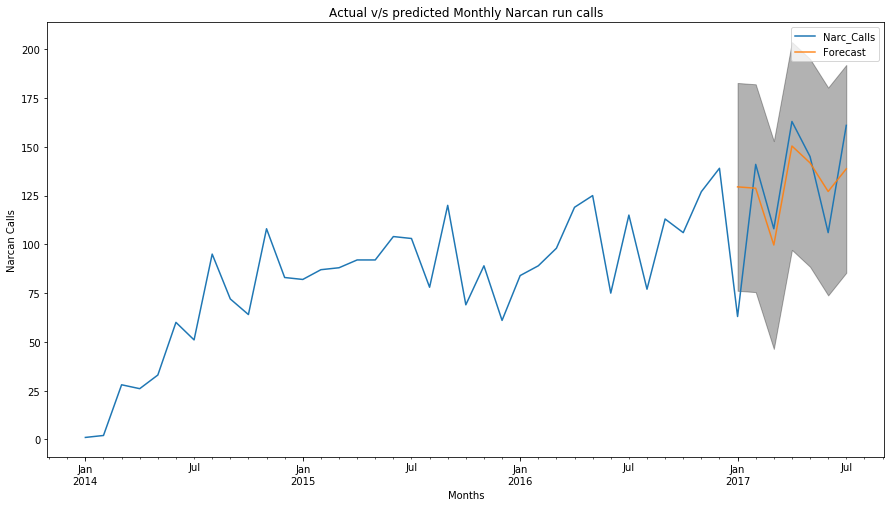

In [64]:
#### ST. JOSEPH

stJoseph_NarcCalls = getData('St. Joseph')

stJoseph_NarcCalls.plot(figsize=(15,6))
plt.title('Monthly Narcan Run calls')
plt.show()

forecastNarcan(stJoseph_NarcCalls)

## Predict for Tippecanoe County.....

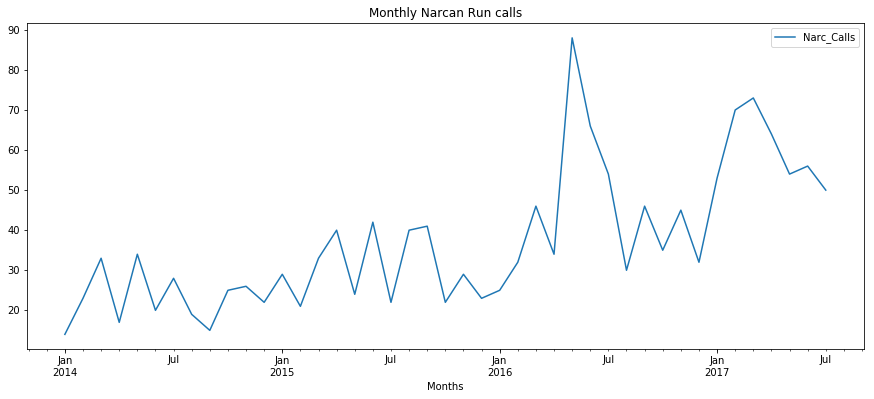

                                 Statespace Model Results                                 
Dep. Variable:                         Narc_Calls   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -127.732
Date:                            Sat, 15 Dec 2018   AIC                            261.465
Time:                                    09:15:09   BIC                            265.668
Sample:                                01-31-2014   HQIC                           262.810
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3607      0.235     -1.533      0.125      -0.822       0.101
ar.S.L12      -0.7262      0.151   

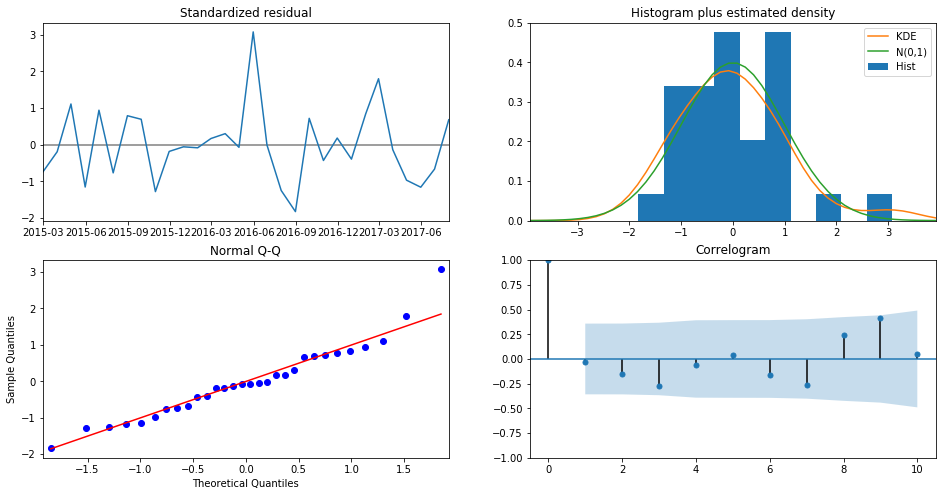

            lower Narc_Calls  upper Narc_Calls
2017-01-31         11.903087         69.457269
2017-02-28         14.785566         72.339748
2017-03-31         46.233478        103.787660
2017-04-30         49.465074        107.019256
2017-05-31         42.283602         99.837784
2017-06-30         37.020552         94.574734
2017-07-31         11.234385         68.788566


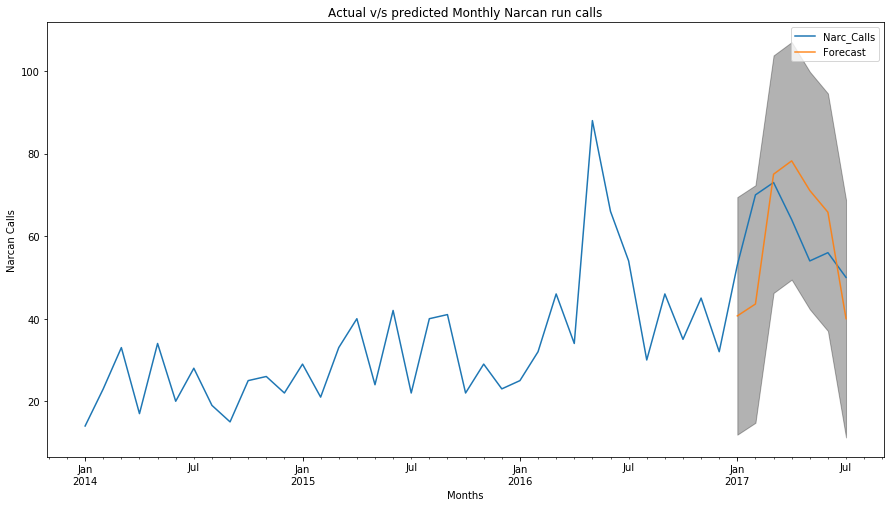

In [66]:
#### ST. JOSEPH

Tippecanoe_NarcCalls = getData('Tippecanoe')

Tippecanoe_NarcCalls.plot(figsize=(15,6))
plt.title('Monthly Narcan Run calls')
plt.show()

forecastNarcan(Tippecanoe_NarcCalls)



## Predict for Vanderburgh County.....

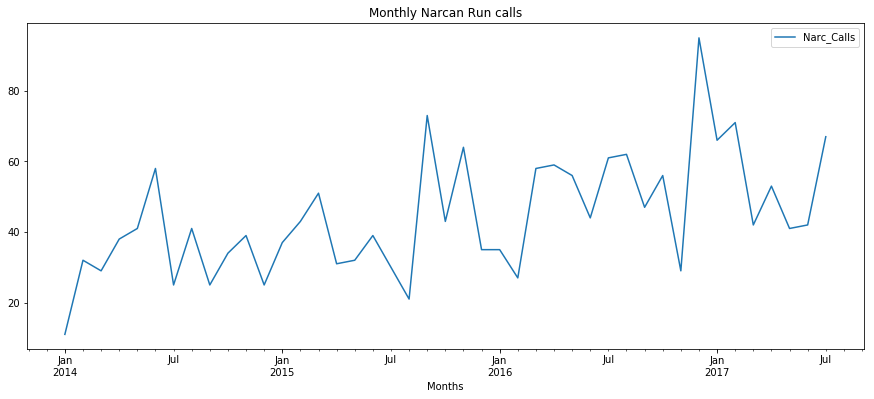

                                 Statespace Model Results                                 
Dep. Variable:                         Narc_Calls   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -138.594
Date:                            Sat, 15 Dec 2018   AIC                            283.187
Time:                                    09:16:57   BIC                            287.391
Sample:                                01-31-2014   HQIC                           284.532
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6096      0.247     -2.467      0.014      -1.094      -0.125
ar.S.L12      -0.5478      0.259   

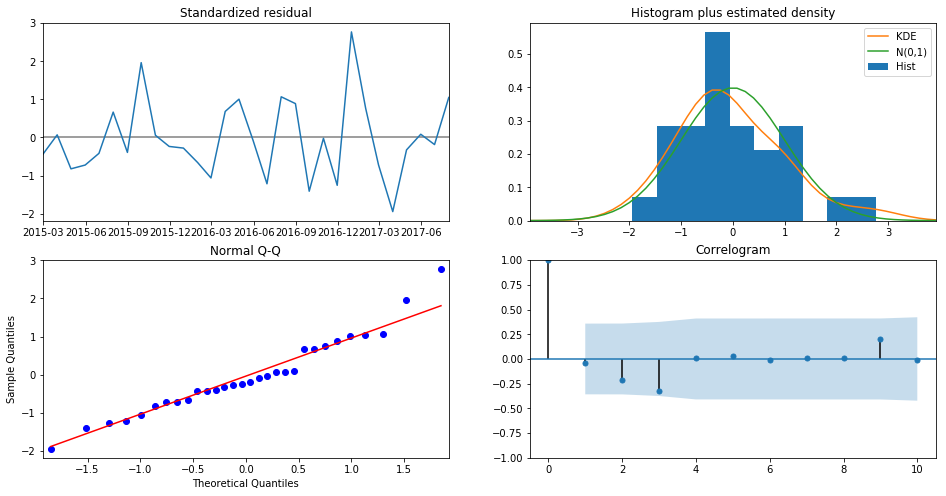

            lower Narc_Calls  upper Narc_Calls
2017-01-31          4.200861         93.148432
2017-02-28         42.879165        131.826737
2017-03-31         41.677555        130.625126
2017-04-30         15.915883        104.863454
2017-05-31         -5.390184         83.557388
2017-06-30          1.755824         90.703396
2017-07-31         -1.296283         87.651289


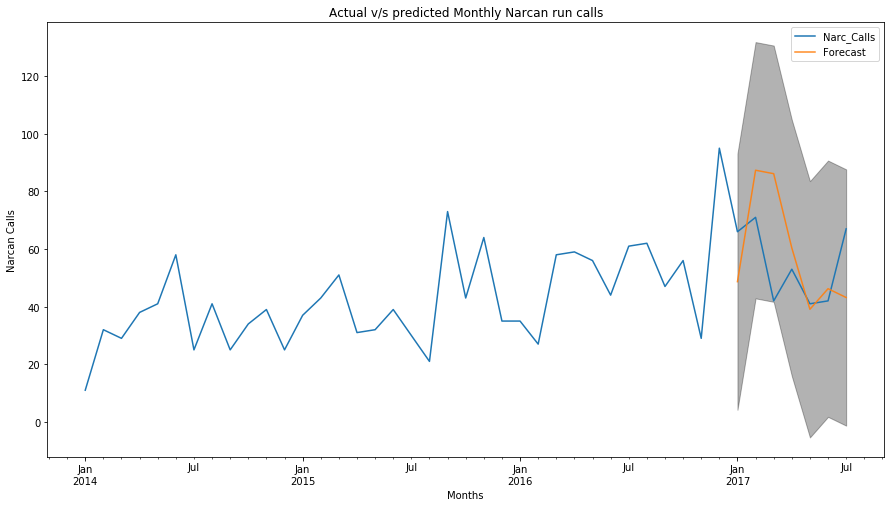

In [67]:
## Vanderburgh

Vanderburgh_NarcCalls = getData('Vanderburgh')

Vanderburgh_NarcCalls.plot(figsize=(15,6))
plt.title('Monthly Narcan Run calls')
plt.show()

forecastNarcan(Vanderburgh_NarcCalls)


## Predict for Delaware County......

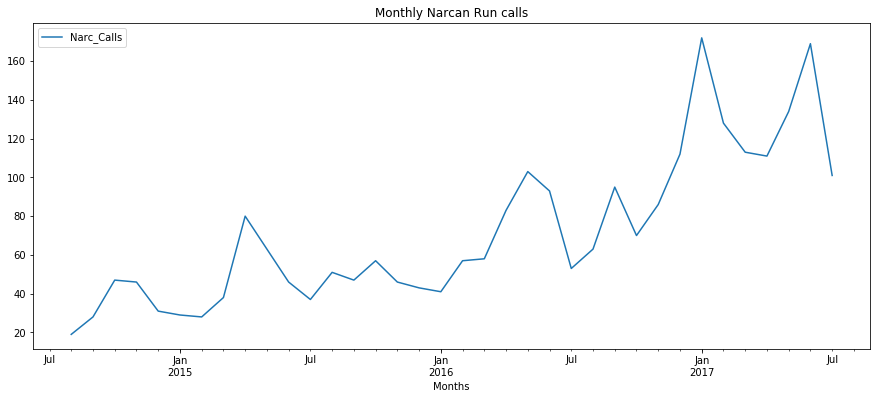

                                 Statespace Model Results                                 
Dep. Variable:                         Narc_Calls   No. Observations:                   36
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -109.261
Date:                            Sat, 15 Dec 2018   AIC                            224.522
Time:                                    09:18:16   BIC                            227.928
Sample:                                08-31-2014   HQIC                           225.379
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2111      0.198     -1.064      0.287      -0.600       0.178
ar.S.L12       0.1305      0.585   

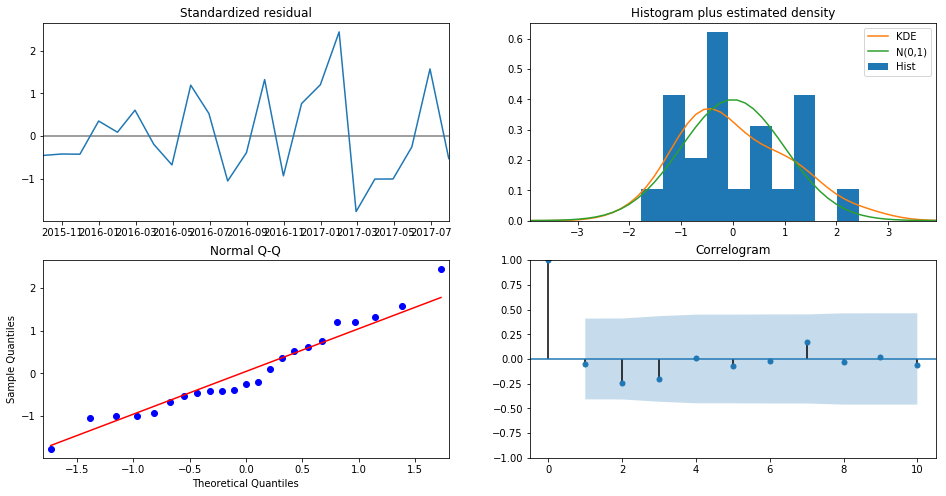

            lower Narc_Calls  upper Narc_Calls
2017-01-31         49.669871        158.749742
2017-02-28        122.593402        231.673273
2017-03-31         86.417356        195.497227
2017-04-30         84.369847        193.449718
2017-05-31         86.520499        195.600370
2017-06-30         70.760147        179.840018
2017-07-31         61.108228        170.188099


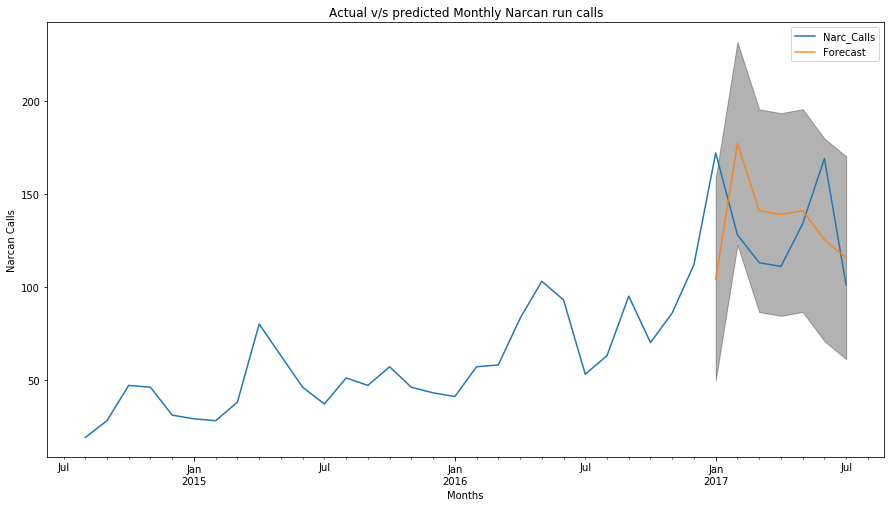

In [69]:
## Delaware


Delaware_NarcCalls = getData('Delaware')

Delaware_NarcCalls.plot(figsize=(15,6))
plt.title('Monthly Narcan Run calls')
plt.show()

forecastNarcan(Delaware_NarcCalls)
